hi, upvotes are appreciated and welcome!

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # graphs, plots etc.
import math # math module

we imported the libraries those we need in this competition

In [2]:
df_train = pd.read_csv('../input/titanic/train.csv')
df_test = pd.read_csv('../input/titanic/test.csv')
df_combined = df_train.append(df_test, ignore_index=False)

we combined our train and test dataset temporarily for useful reasons and getting information about whole dataset

In [3]:
df_combined.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


we will follow these steps:
1. Visualize graphs and find correlations between features and survived rate
2. Cleanse our data and deal with NaN values
3. Concatenate related columns for concise features
4. Remove features which is not related with survival chance
5. Try different ML algorithms to get best scores and sort them with respect to final scores

In [4]:
Pclass = df_combined.groupby(['Pclass']).mean()
Pclass['Survived'].head()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

as wee see, first ticket class has the highest survival rate and third one has the lowest

Let's visualize it!

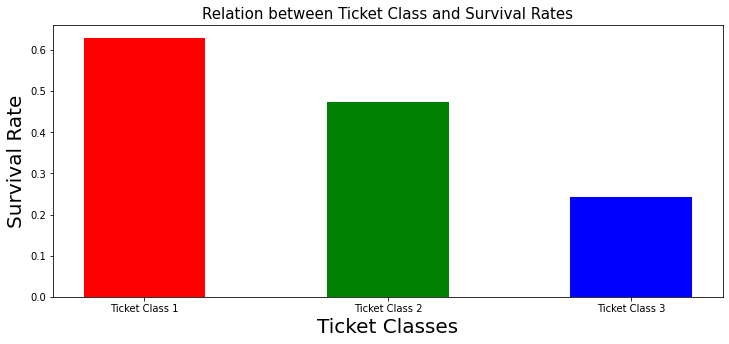

In [5]:
X = ['Ticket Class 1','Ticket Class 2','Ticket Class 3']
plclsses = [Pclass['Survived'].head().values[0],Pclass['Survived'].head().values[1],Pclass['Survived'].head().values[2]]
  
X_axis = np.arange(len(X))
f, ax = plt.subplots(figsize=(12, 5))
plt.bar(X_axis, plclsses, 0.5, color=['red', 'green', 'blue'])
  
plt.xticks(X_axis, X)
plt.xlabel("Ticket Classes", fontsize=20)
plt.ylabel("Survival Rate", fontsize=20)
plt.title("Relation between Ticket Class and Survival Rates", fontsize=15)
plt.show()

In [6]:
Gender = df_combined.groupby(['Sex']).mean()
Gender['Survived'].head()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

as we see, female passengers has way higher survival rates than male passengers.

Let's visualize it!

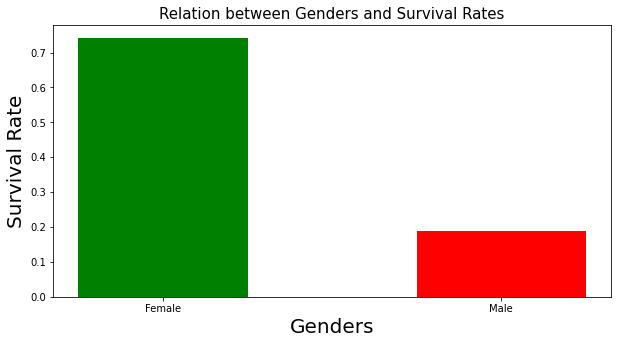

In [7]:
X = ['Female','Male']
pltclsses = [Gender['Survived'].head().values[0],Gender['Survived'].head().values[1]]
  
X_axis = np.arange(len(X))
f, ax = plt.subplots(figsize=(10, 5))
plt.bar(X_axis, pltclsses, 0.5, color=['green', 'red'])
  
plt.xticks(X_axis, X)
plt.xlabel("Genders", fontsize=20)
plt.ylabel("Survival Rate", fontsize=20)
plt.title("Relation between Genders and Survival Rates", fontsize=15)
plt.show()

In [8]:
#x = df_combined.loc[df_combined['Parch'] > 0]
df_combined = df_combined.reset_index(drop=True) # reseting indices to prevent any type of issues

In [9]:
my_mean = math.ceil(df_combined['Age'].mean()) # mean is ~= 30
my_std = math.ceil(df_combined['Age'].std()) # std is ~= 15
size = df_combined['Age'].isnull().values.sum() # We have 177 NaN values in Age column
ageArray = np.random.normal(loc=my_mean, scale=my_std, size=size)
for i in range(ageArray.shape[0]):
    if ageArray[i] < 0:
        ageArray[i] = my_mean

ageArray = np.ceil(ageArray)       
templ = 0
for i, _ in enumerate(df_combined['Age']):
    if np.isnan(df_combined.loc[i, 'Age']):
        df_combined.loc[i, 'Age'] = ageArray[templ]
        templ = templ+1

df_combined['Age'] = df_combined['Age'].apply(np.ceil) # Let's ceil the age values, because float numbers are unacceptable as age
df_combined.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1309.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,30.197861,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.176470,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,29.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [10]:
df_combined.head()
df_combined['Age'] = df_combined['Age'].astype(int) # Default data type of Age column was float64, we're gonna use int64 instead
df_combined.dtypes

PassengerId      int64
Survived       float64
Pclass           int64
Name            object
Sex             object
Age              int64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

as you can notice, there are 2 columns are about the family attributes (sibsp and parch), we can assemble them into two binary features e.g. HasFamily = 0 or 1

Let's code it!

In [11]:
df_combined['HasFamily'] = 0
for x in range(df_combined.shape[0]):
    if df_combined.loc[x]['SibSp'] > 0 or df_combined.loc[x]['Parch'] > 0:
        df_combined.loc[x ,['HasFamily']] = 1

now let's check it!

In [12]:
df_combined.tail(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasFamily
1299,1300,NaN,3,"Riordan, Miss. Johanna Hannah""""",female,49,0,0,334915,7.7208,NaN,Q,0
1300,1301,NaN,3,"Peacock, Miss. Treasteall",female,3,1,1,SOTON/O.Q. 3101315,13.7750,NaN,S,1
1301,1302,NaN,3,"Naughton, Miss. Hannah",female,23,0,0,365237,7.7500,NaN,Q,0
1302,1303,NaN,1,"Minahan, Mrs. William Edward (Lillian E Thorpe)",female,37,1,0,19928,90.0000,C78,Q,1
1303,1304,NaN,3,"Henriksson, Miss. Jenny Lovisa",female,28,0,0,347086,7.7750,NaN,S,0
1304,1305,NaN,3,"Spector, Mr. Woolf",male,44,0,0,A.5. 3236,8.0500,NaN,S,0
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39,0,0,PC 17758,108.9000,C105,C,0
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,39,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0
1307,1308,NaN,3,"Ware, Mr. Frederick",male,52,0,0,359309,8.0500,NaN,S,0
1308,1309,NaN,3,"Peter, Master. Michael J",male,34,1,1,2668,22.3583,NaN,C,1


now it works, we have a new column named as HasFamily so now we can get rid of SibSp and Parch columns

name feature is also not really helpful for our algorithm we can drop it too

also we're gonna drop unknown 'Survived' values (PassengerId and Ticket Number is also not really decisive for our algorithm)

In [13]:
df_combined.drop(['SibSp', 'Parch', 'Name', 'PassengerId', 'Ticket'], inplace=True, axis=1)
df_combined = df_combined[df_combined['Survived'].notna()] 
df_combined.describe()

,Survived,Pclass,Age,Fare,HasFamily
count,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,30.130191,32.204208,0.397306
std,0.486592,0.836071,14.292644,49.693429,0.489615
min,0.000000,1.000000,1.000000,0.000000,0.000000
25%,0.000000,2.000000,21.000000,7.910400,0.000000
50%,0.000000,3.000000,29.000000,14.454200,0.000000
75%,1.000000,3.000000,39.000000,31.000000,1.000000
max,1.000000,3.000000,80.000000,512.329200,1.000000


as you can see above, we have some NaN age values

but we are not gonna drop them, we will replace them with mean value of age instead

We're gonna categorise our Age label to graphing it in more convenient way

In [14]:
df_combined['AgeCategory'] = pd.cut(df_combined['Age'], 8, labels=['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '70-80', '80-90'])
Age = df_combined.groupby(['Age']).mean()
Age['Survived'].head(8)

Age
1    0.800000
2    0.300000
3    0.833333
4    0.700000
5    1.000000
6    0.333333
7    0.400000
8    0.333333
Name: Survived, dtype: float64

now we have 8 age bins

as we can see highest survival rate belongs to third age category (20-30)

lowest survival rate belongs to the seventh category (70-80)

now we can visualize it to understand better

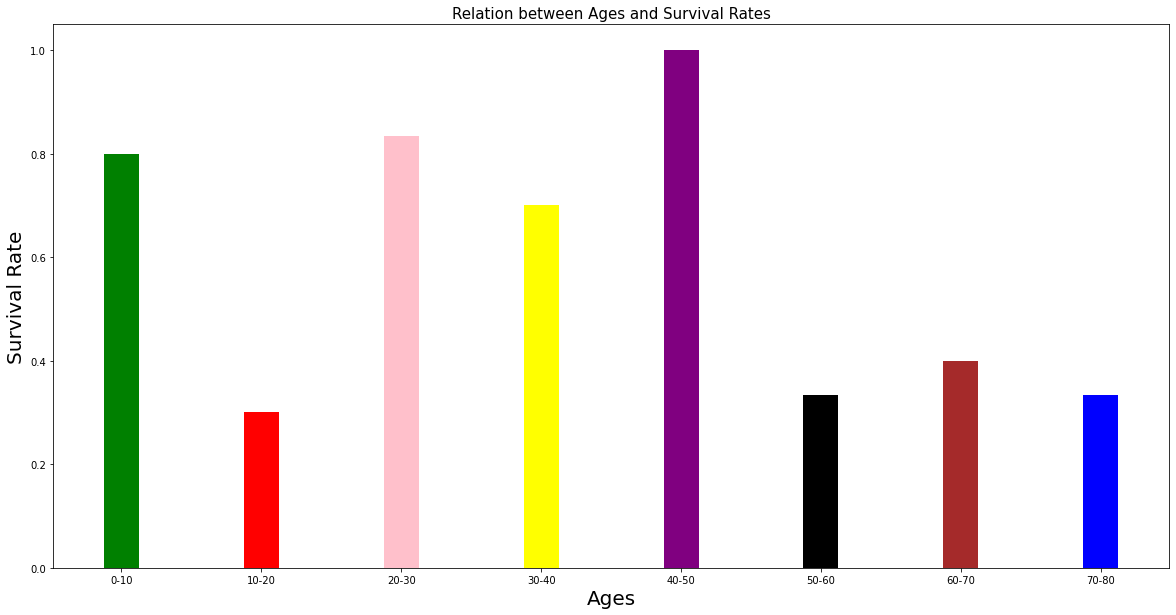

In [15]:
X = ['0-10','10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80']
pltclsses = [Age['Survived'].head(8).values[0], Age['Survived'].head(8).values[1], Age['Survived'].head(8).values[2], Age['Survived'].head(8).values[3],
             Age['Survived'].head(8).values[4], Age['Survived'].head(8).values[5], Age['Survived'].head(8).values[6], Age['Survived'].head(8).values[7]]
  
X_axis = np.arange(len(X))
f, ax = plt.subplots(figsize=(20, 10))
plt.bar(X_axis, pltclsses, 0.25, color=['green', 'red', 'pink', 'yellow', 'purple', 'black', 'brown', 'blue'])
  
plt.xticks(X_axis, X)
plt.xlabel("Ages", fontsize=20)
plt.ylabel("Survival Rate", fontsize=20)
plt.title("Relation between Ages and Survival Rates", fontsize=15)
plt.show()


In [16]:
df_combined.isnull().sum()
df_combined.count()

Survived       891
Pclass         891
Sex            891
Age            891
Fare           891
Cabin          204
Embarked       889
HasFamily      891
AgeCategory    891
dtype: int64

we have mostly NaN Cabin values, hence we will drop them too 

In [17]:
df_combined.drop(['Cabin', 'AgeCategory'], axis=1, inplace=True) # and also our temporary AgeCategory column
df_combined = df_combined[df_combined['Embarked'].notna()]

In [18]:
df_combined.isnull().sum() # = 0
df_combined.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,HasFamily
0,0.0,3,male,22,7.2500,S,1
1,1.0,1,female,38,71.2833,C,1
2,1.0,3,female,26,7.9250,S,0
3,1.0,1,female,35,53.1000,S,1
4,0.0,3,male,35,8.0500,S,0


now our dataset is ready to train!

we will split it before training

In [19]:
temp_df = pd.get_dummies(df_combined) # we are creating dummies for model compatibility
from sklearn.model_selection import train_test_split

train, test = train_test_split(temp_df, test_size=0.2)
#train = train.to_numpy()
#test = test.to_numpy()

now we have train and test datasets

let's create our x and y sets!

In [20]:
y_train = train['Survived']
X_train = train.loc[:, train.columns != 'Survived']
y_test = test['Survived']
X_test = test.loc[:, test.columns != 'Survived'] 

now all done! finally we're ready for training stage

In [21]:
from sklearn import tree
from sklearn import metrics 

model = tree.DecisionTreeClassifier()
model = model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7359550561797753
